In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from scipy import stats
import pandas as pd
from numpy.random import seed
import numpy as np

import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk",font_scale=0.75)

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Data simulation

Consider an experiment including 100 participants. Every participant filled out an anxiety questionnaire, on which they received some score. Participants were peresented with certain stimuli which is known to evoke different reponses in three ROIs: mean response of **1.65**, **-1.96**, and **0** in **ROI1**, **ROI2**, and **ROI3**, respectively.

The ROI responses also vary with anxiety score as follows:  
- ROI1: A unit increase in anxiety results 0.5 increase in response (slope of **0.5**)  
- ROI2: No change (slope of **0**)  
- ROI3: A unit increase in anxiety results in -1 decrease in response (slope of **-1**) 

Hence, data generation model looks like:

$$y_{roi_{1}}  = \mu_{roi_{1}} + 0.5*anxiety_z$$
$$y_{roi_{2}}  = \mu_{roi_{2}}$$
$$y_{roi_{3}}  = \mu_{roi_{3}} - 1*anxiety_z$$

$$\mu_{roi_{1}} \sim N(1.65,1)$$
$$\mu_{roi_{2}} \sim N(-1.96,1)$$
$$\mu_{roi_{3}} \sim N(0,1)$$

In [3]:
mu_ROI1 = 1.65
mu_ROI2 = -1.96
mu_ROI3 = 0

In [4]:
seed(47)
anxiety = stats.norm.rvs(loc=5,scale=2,size=100)
anxiety_Z = stats.zscore(anxiety)

In [5]:
# Genarate the data using the equations above
df = pd.DataFrame()
for score in anxiety_Z:
    roi1 = stats.norm.rvs(loc=mu_ROI1,scale=1,size=1)[0] + 0.5*score
    roi2 = stats.norm.rvs(loc=mu_ROI2,scale=1,size=1)[0]
    roi3 = stats.norm.rvs(loc=mu_ROI3,scale=1,size=1)[0] + (-1)*score
    
    tmp_df = pd.DataFrame({'y':[roi1,roi2,roi3],'ROI':['roi1','roi2','roi3'],'anxiety':[2*score + 5]*3})
    df = pd.concat([df,tmp_df],axis=0,ignore_index=True)
    
print('Simulated data:')
df['anxiety_Z'] = stats.zscore(df['anxiety'])
print(df.head())

Simulated data:
          y   ROI   anxiety  anxiety_Z
0  0.264788  roi1  3.397532  -0.801234
1 -1.556800  roi2  3.397532  -0.801234
2  1.734090  roi3  3.397532  -0.801234
3  2.308506  roi1  7.495783   1.247892
4 -1.597569  roi2  7.495783   1.247892


## Model 1: Only varying intercepts
lme4-like notation:
    $$y = 1 + anxiety + (1 | ROI)$$
    
Full model (in the notation of McElreath 2020):

$$y = \alpha_{0} + \alpha_{ROI} + \beta_{anxiety}*anxiety + \epsilon$$

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: y        
No. Observations:  300     Method:             REML     
No. Groups:        3       Scale:              1.3518   
Min. group size:   100     Log-Likelihood:     -474.3800
Max. group size:   100     Converged:          Yes      
Mean group size:   100.0                                
--------------------------------------------------------
          Coef.    Std.Err.     z    P>|z| [0.025 0.975]
--------------------------------------------------------
ROI[roi1]  1.655        1.168  1.417 0.157 -0.635  3.946
ROI[roi2] -1.913        1.168 -1.637 0.102 -4.203  0.377
ROI[roi3]  0.139        1.168  0.119 0.905 -2.151  2.429
anxiety_Z -0.182        0.067 -2.715 0.007 -0.314 -0.051
Group Var  1.352 15302138.338                           



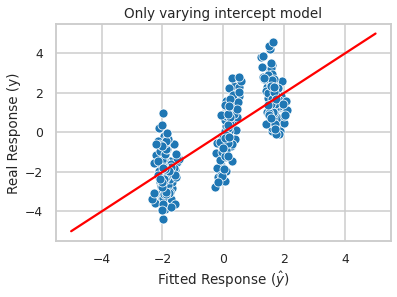

In [6]:
# without covariate
model1 = smf.mixedlm(formula='y ~ -1 + anxiety_Z + ROI',data=df,groups=df["ROI"]).fit()
sns.scatterplot(model1.fittedvalues,df.y)
plt.plot([-5, 5], [-5, 5], c = "red")
_=plt.xlabel(r'Fitted Response ($\hat{y}$)')
_=plt.ylabel('Real Response (y)')
_=plt.title('Only varying intercept model')
print(model1.summary())

Since ROIs are only allowed to have individual intercepts, the model estimated only mean response for each ROI.

## Model 2: Varying intercepts and varying slopes
lme4-like notation:
    $$y = 1 + anxiety + (1 + anxiety | ROI)$$
    
Full model (in the notation of McElreath 2020):

$$y = \alpha_{0} + \alpha_{ROI} + (\beta_{anxiety}+\beta_{ROI_{anxiety}})*anxiety + \epsilon$$

               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     y        
No. Observations:     300         Method:                 REML     
No. Groups:           3           Scale:                  0.9912   
Min. group size:      100         Log-Likelihood:         -432.4608
Max. group size:      100         Converged:              Yes      
Mean group size:      100.0                                        
-------------------------------------------------------------------
                      Coef.    Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
ROI[roi1]              1.655                                       
ROI[roi2]             -1.913                                       
ROI[roi3]              0.139                                       
anxiety_Z             -0.182       0.426 -0.428 0.669 -1.017  0.652
Group Var              0.991 8774008.217                       

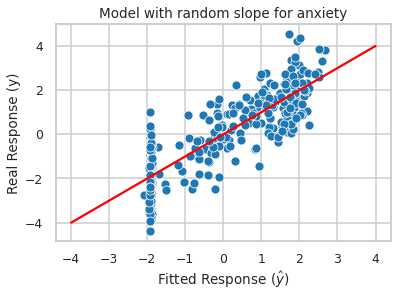

In [7]:
# with covariate
model2 = smf.mixedlm(formula='y ~ -1 + anxiety_Z + ROI',
                     data=df,groups=df["ROI"],re_formula="anxiety_Z").fit()
sns.scatterplot(model2.fittedvalues,df.y)
plt.plot([-4, 4], [-4, 4], c = "red")
_=plt.xlabel(r'Fitted Response ($\hat{y}$)')
_=plt.ylabel('Real Response (y)')
_=plt.title('Model with random slope for anxiety')
print(model2.summary())

The fit achieved by this `Model 2` is much better than `Model 1`. ROIs are also allowed to have individual slopes (with respect to anxiety). Hence, for each ROI the model is able to estimate responses at every level of the covariate. 

## Comparison of the Estimated effects with the Real effects 

In [8]:
re = model2.random_effects
fe = model2.fe_params.to_dict()

In [9]:
estimates = pd.DataFrame()
for roi in ['roi%i' %(i) for i in range(1,4)]:
    #intercept = fe['Intercept'] + re[roi]['Group']
    intercept = fe['ROI[{}]'.format(roi)] + re[roi]['Group']
    slope = fe['anxiety_Z'] + re[roi]['anxiety_Z']
    estimates = pd.concat([estimates,pd.DataFrame([intercept,slope],index=['Est. Mean Response','Est. Slope for Anxiety'],columns=[roi]).T],ignore_index=False)
    
real = pd.DataFrame({'Real Mean Response':[mu_ROI1,mu_ROI2,mu_ROI3],'Real Slope for Anxiety':[0.5,0,-1]},index=['roi%i' %(i) for i in range(1,4)])

In [10]:
summary = estimates.join(real)
summary.index.name = 'ROI'
summary.reset_index(inplace=True)
summary = summary.melt(id_vars='ROI',var_name='effect',value_name='estimate')

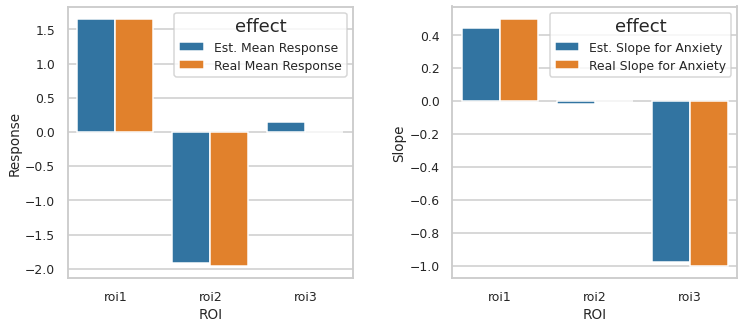

In [11]:
plt.figure(figsize=(12,5))
plt.subplots_adjust(wspace=.35)
plt.subplot(1,2,1)
sns.barplot(x='ROI',y='estimate',hue='effect',data=summary[summary['effect'].isin([e for e in summary.effect.unique() if 'Mean' in e])])
plt.ylabel('Response')
plt.subplot(1,2,2)
sns.barplot(x='ROI',y='estimate',hue='effect',data=summary[summary['effect'].isin([e for e in summary.effect.unique() if 'Anxiety' in e])])
_=plt.ylabel('Slope')

In [12]:
df.drop('anxiety_Z',axis=1).to_csv('data_for_condidates.txt',
                                   sep=',',
                                   float_format='%.4f',
                                   index=False)